In [2]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.base import clone
from scipy.io import loadmat
from scipy.stats import pearsonr
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
from sklearn.svm import LinearSVC
import pickle

In [3]:
class ClassifierBundle():
    def __init__(self):
        self.classifiers = {}

    def addClassifier(self,index, clf):
        if index not in self.classifiers.keys():
            self.classifiers[index]=[]
        self.classifiers[index].append(clf)

    def getClassifiers(self):
        return self.classifiers

    def numberOfClassifiers(self, index):
        if index not in self.classifiers.keys():
            return 0
        else:
            return len(self.classifiers[index])

In [4]:
class PredictionsBundle():
    def __init__(self):
        self.predictions = {}

    def addPrediction(self,index, pred):
        if index not in self.predictions.keys():
            self.predictions[index]=[]
        self.predictions[index].append(pred)

    def getPredictions(self):
        return self.predictions

In [5]:
class dataToClassifier():
    def __init__(self):
        self.data = None
        self.target = None
        
    def addData(self, X, y):
        if self.data is None:
            self.data = X
            self.target = y
        else:
            self.data = np.vstack((self.data, X))
            self.target = np.hstack((self.target, y))

In [6]:
class DataHandler():
    def __init__(self, dataset, trainSize):
        self.trainSize = trainSize
        self.dataset = dataset.copy()
        self.trialsToUse = np.arange(dataset.shape[2])
        self.timesToUse = np.arange(dataset.shape[1])
        self.nDimensions= dataset.shape[0]
        
    def getTrialsData(self,trialIndexes):
        allTrialsData = dataToClassifier()
        for itrial in trialIndexes:
            X,y = self.oneTrialData(itrial)
            allTrialsData.addData(X,y)
        return allTrialsData
    
    def oneTrialData(self,trialIndex):
        X = np.transpose(self.dataset[:,:,trialIndex])
        y = self.timesToUse
        return X, y
        
    def getTrainIndexes(self,testTrial):
        nonTestTrials = list(self.trialsToUse)
        nonTestTrials.remove(testTrial)
        trainIndexes = np.random.choice(nonTestTrials, self.trainSize, replace=False)
        return trainIndexes
    
    def trialShuffle(self):
        for i in range(self.nDimensions):
            for j in self.timesToUse:
                np.random.shuffle(self.dataset[i,j,:])
                
    def binShuffle(self):
        for i in range(self.nDimensions):
            for k in self.trialsToUse:
                np.random.shuffle(self.dataset[i,:,k])

In [7]:
class PredictionsHandler():
    def __init__(self):
        pass

    def predictAllResults(self, dataHandl, clfBox):
        predBox = PredictionsBundle()
        classifiers = clfBox.getClassifiers()
        
        for iTestTrial in dataHandl.trialsToUse:
            for iclf in classifiers[iTestTrial % (len(classifiers.keys()) ) ]:
                trialsData = dataHandl.getTrialsData([iTestTrial])
                predBox.addPrediction(iTestTrial, iclf.predict(trialsData.data))
        return predBox

    def correlate(self, predBox, target, makeStd=False):
        correlations = []
        deviations = []
        predictions = predBox.getPredictions()
        for trial in predictions.keys():
            correlations.append(np.mean(np.nan_to_num([ pearsonr(pred,target)[0]
                                                       for pred in predictions[trial]] ) ) )
            if makeStd:
                deviations.append(np.std(np.nan_to_num([ pearsonr(pred,target)[0]
                                                       for pred in predictions[trial]] ) ) )
        correlations = np.array(correlations)
        
        if makeStd:
            return correlations, np.array(deviations)
        
        return correlations



class ClassifierHandler():
    def __init__(self, Nclf_ForEachTrial, clf=SVC(),bestClassifier = None):
        self.bestClassifier = bestClassifier
        self.clf = clf
        self.Nclf_ForEachTrial = Nclf_ForEachTrial

    def generateClassifiers(self,dataHandl):
        clfBox = ClassifierBundle()
        for iTestTrial in dataHandl.trialsToUse:
            while clfBox.numberOfClassifiers(iTestTrial) < self.Nclf_ForEachTrial:
                self.__generateAndAddClassifier(iTestTrial,dataHandl, clfBox)
        return clfBox

    def __generateAndAddClassifier(self,testTrial,dataHandl,clfBox):
        trainIndexes = dataHandl.getTrainIndexes(testTrial)
        clf = self.__trainOneClassifier(trainIndexes, dataHandl)
        #clfBox.addClassifier(testTrial,clf)
        self.__addClassifierToAll(trainIndexes, clf, dataHandl, clfBox)

    def __trainOneClassifier(self,trainIndexes,dataHandl):
        if self.bestClassifier is None:
            self.__gridSearch(dataHandl)
        clf = clone(self.bestClassifier)
        trialsData = dataHandl.getTrialsData(trainIndexes)
        clf.fit(trialsData.data,trialsData.target)
        return clf

    def __addClassifierToAll(self,trainIndexes, clf, dataHandl, clfBox):
        possibleTestTrials = list( set(dataHandl.trialsToUse)-set(trainIndexes) )
        for eachTrial in possibleTestTrials:
            if clfBox.numberOfClassifiers(eachTrial) < self.Nclf_ForEachTrial:
                clfBox.addClassifier(eachTrial,clf)

    def __gridSearch(self, dataHandl):
        grid_trials = dataHandl.trialsToUse
        trialsData = dataHandl.getTrialsData(grid_trials)

        clf = clone(self.clf)
        grid = GridSearchCV(clf, self.__gridParams(), cv=5)
        grid.fit(trialsData.data,trialsData.target)

        self.bestClassifier = grid.best_estimator_

    def __gridParams(self):
        if type(self.clf) == SVC:
            C_grid = range(1,17);
            Gamma_grid = np.linspace(0.1,2,20)*1./40
            return {'C':C_grid,'gamma':Gamma_grid}
        if type(self.clf) == LinearSVC:
            C_grid = range(1,17);
            return {'C':C_grid}
        else: raise Exception(str(type(self.clf))+ 'Non-supported Classifier type!!!')
    def reset_grid(self):
        self.bestClassifier = None


#### Load Dataset

In [7]:
ratset = loadmat('data_R10.mat')['C2']
ratset.shape

FileNotFoundError: [Errno 2] No such file or directory: 'data_R10.mat'

# Comparing beginning and end
## Training classifier with ending trials

In [42]:
trialsToUse = range(650,753)
timesToUse = range(0,20)
trainSize = 60
neuronsToUse = 40

endingDS = ratset[:50,:20,620:750]
beginningDS = ratset[:50,:20,100:150]
dataset = endingDS
dataset.shape

(50, 20, 130)

In [43]:
dataTrialShuffle = DataHandler(dataset, 80)
dataTrialShuffle.trialShuffle()

dataBinShuffle = DataHandler(dataset, 80)
dataBinShuffle.trialShuffle()
dataBinShuffle.binShuffle()


trainer1 = ClassifierHandler(30, LinearSVC())
trainer2 = ClassifierHandler(30,LinearSVC())



In [44]:
%time goodClfBox = trainer1.generateClassifiers(dataTrialShuffle)
%time badClfBox = trainer2.generateClassifiers(dataBinShuffle)

print('Done')

CPU times: user 10min 52s, sys: 25.6 s, total: 11min 17s
Wall time: 10min 48s
CPU times: user 11min 25s, sys: 25.7 s, total: 11min 51s
Wall time: 11min 21s
Done


### T test and KS test

In [45]:
import scipy.stats as st
predMaker = PredictionsHandler()
goodPredBox = predMaker.predictAllResults(dataTrialShuffle,goodClfBox)
badPredBox = predMaker.predictAllResults(dataBinShuffle,badClfBox)

latePreds = predMaker.correlate(goodPredBox, range(0,20))
badPreds = predMaker.correlate(badPredBox, range(0,20))

In [53]:
print(badPreds.mean())
print(badPreds.std())

-0.0176355279957
0.099011137478


In [46]:
ttest_late_bad = st.ttest_ind(latePreds,badPreds,equal_var=False)
#ttest_late_early = st.ttest_ind(latePreds,badPreds,equal_var=False)
#ttest_early_bad = st.ttest_ind(latePreds,badPreds,equal_var=False)
ttest_late_bad

Ttest_indResult(statistic=19.8761784933379, pvalue=5.3202548708406062e-52)

In [47]:
badNormParams = st.norm.fit(badPreds)
lateNormParams = st.norm.fit(latePreds)

In [48]:
x = np.linspace(-1,1,30)
badPdf = st.norm.pdf(x, badNormParams[0],badNormParams[1])
latePdf =st.norm.pdf(x, lateNormParams[0],lateNormParams[1])

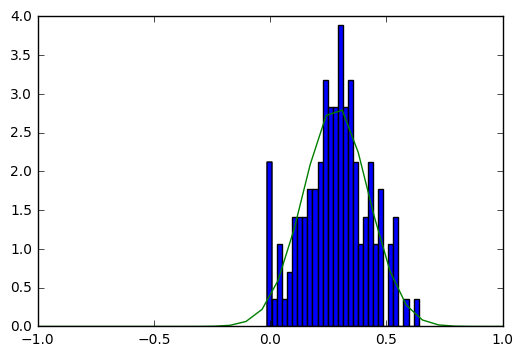

In [49]:
plt.hist(latePreds,30,normed=1)
plt.plot(x,latePdf)

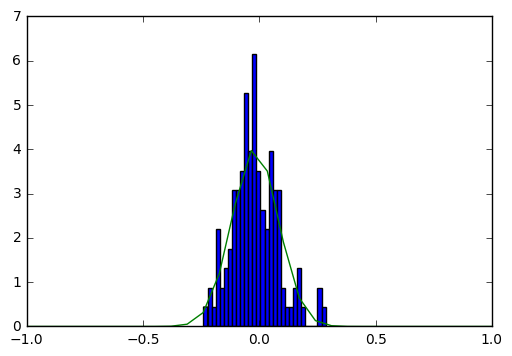

In [50]:
plt.hist(badPreds,30,normed=1)
plt.plot(x,badPdf)

In [51]:
KStest = st.ks_2samp(latePreds,badPreds)
KStest

Ks_2sampResult(statistic=0.80769230769230771, pvalue=1.7311045298017099e-38)

In [ ]:
lateTrials= DataHandler(dataset, trainSize)
lateTrials.trialShuffle()
earlyTrials= DataHandler(dataset, trainSize)
earlyTrials.trialShuffle()

earlyTrainer = ClassifierHandler(30)
earlyClfBox = earlyTrainer.generateClassifiers(earlyTrials)

# Automate process

In [7]:
#endingDS = dataset[:40,:20,650:750]
#beginningDS = dataset[:40,:20,50:150]
#timesToUse = np.arange(20)
def late_early_bad(endingDS, beginningDS, timesToUse, trainSize, clf=SVC()):

    badData = DataHandler(endingDS, trainSize)
    badData.trialShuffle()
    badData.binShuffle()
    lateData = DataHandler(endingDS, trainSize)
    lateData.trialShuffle()
    earlyData = DataHandler(beginningDS, trainSize)
    earlyData.trialShuffle()
    
    trainerLate = ClassifierHandler(30,clf)
    trainerEarly= ClassifierHandler(30,clf)
    trainerBad = ClassifierHandler(30,clf)
    predMaker = PredictionsHandler()
    
    clfLateBox = trainerLate.generateClassifiers(lateData)
    clfEarlyBox = trainerEarly.generateClassifiers(earlyData)
    clfBadBox = trainerBad.generateClassifiers(badData)
    
    
    latePreds = predMaker.predictAllResults(lateData, clfLateBox)
    earlyPreds = predMaker.predictAllResults(earlyData, clfEarlyBox)
    badPreds = predMaker.predictAllResults(badData, clfBadBox)
    mixedPreds = predMaker.predictAllResults(earlyData, clfLateBox)

    
    lateCorrs = predMaker.correlate(latePreds, timesToUse)
    earlyCorrs = predMaker.correlate(earlyPreds, timesToUse)
    badCorrs = predMaker.correlate(badPreds, timesToUse)
    mixedCorrs = predMaker.correlate(mixedPreds, timesToUse)
    
    meanStdCorr = {}
    t_tests = {}
    KStests = {}
    allCorrs = {}
    
    meanStdCorr['early'] = (earlyCorrs.mean(), earlyCorrs.std())
    meanStdCorr['late'] = (lateCorrs.mean(), lateCorrs.std())
    meanStdCorr['bad'] = (badCorrs.mean(), badCorrs.std())
    meanStdCorr['mixed'] = (mixedCorrs.mean(), mixedCorrs.std())
             
    t_tests['early_late'] = st.ttest_ind(lateCorrs,earlyCorrs,equal_var=False).pvalue
    t_tests['early_bad'] = st.ttest_ind(earlyCorrs,badCorrs,equal_var=False).pvalue
    t_tests['bad_late'] = st.ttest_ind(lateCorrs,badCorrs,equal_var=False).pvalue
    t_tests['mixed'] = st.ttest_ind(earlyCorrs,mixedCorrs,equal_var=False).pvalue
    
    KStests['early_late'] = st.ks_2samp(lateCorrs,earlyCorrs).pvalue
    KStests['early_bad'] = st.ks_2samp(badCorrs,earlyCorrs).pvalue
    KStests['bad_late'] = st.ks_2samp(lateCorrs,badCorrs).pvalue
    KStests['mixed'] = st.ks_2samp(earlyCorrs,mixedCorrs).pvalue
    
    allCorrs['late'] = lateCorrs
    allCorrs['early'] = earlyCorrs
    allCorrs['bad'] = badCorrs
    allCorrs['mixed'] = mixedCorrs
    
    return t_tests, KStests, meanStdCorr, allCorrs

In [8]:
def makeHist(allCorrs,nbins=25):
    x = np.linspace(-1,1,nbins)
    lateHist = np.histogram(allCorrs['late'],nbins,range=(-1,1))[0]
    earlyHist = np.histogram(allCorrs['early'],nbins,range=(-1,1))[0]
    badHist = np.histogram(allCorrs['bad'],nbins,range=(-1,1))[0]
    mixedHist = np.histogram(allCorrs['mixed'],nbins,range=(-1,1))[0]

    plt.plot(x,lateHist,linewidth=2,label='late')
    plt.plot(x,earlyHist,linewidth=2,label='early')
    plt.plot(x,badHist,linewidth=2,label='bad')
    plt.plot(x,mixedHist,linewidth=2,label='mixed')
    plt.legend(loc='upper left')
    
def printMeanStd(mean_std):
    print('Before training (first trials):')
    print('Mean corr: ' + str(mean_std['early'][0]) + ', std: ' +str(mean_std['early'][1]) )
    print('After training (last trials):')
    print('Mean corr: ' + str(mean_std['late'][0]) + ', std: ' +str(mean_std['late'][1]) )
    print('Mixed predictions (Training late to test early)')
    print('Mean corr: ' + str(mean_std['mixed'][0]) + ', std: ' +str(mean_std['mixed'][1]) )
    print('Surrogate (bin shuffled)')
    print('Mean corr: ' + str(mean_std['bad'][0]) + ', std: ' +str(mean_std['bad'][1]) )


## Lots of tests

In [9]:
ls

correlations.png  decoder.ipynb  normbin_r10.mat  normbin_r8.mat  README.md


# Testing Big bins (of 100ms)

#### Rato 10

In [55]:
bigR10 = loadmat('bigbin_r10.mat')['C']
bigR10 = np.nan_to_num(np.swapaxes(bigR10,0,2))
bigR10.shape

endingDS = bigR10[:40,:10,-100:]
beginningDS = bigR10[:40,:10,:100]
timesToUse = range(10)
trainSize = 80

In [56]:
t,k,mean_std,allCorrs = late_early_bad(endingDS, beginningDS, timesToUse, trainSize, clf=SVC())

In [57]:
print('T test results: ')
print(t)
print('Mean    /    Std')
print(mean_std)
makeHist(allCorrs)

T test results: 
{'early_bad': 4.0557580353726197e-08, 'bad_late': 6.5429677750065373e-35, 'mixed': 0.048717967046418502, 'early_late': 4.554576823978505e-18}
Mean    /    Std
{'early': (0.22562723438027427, 0.24140584279157951), 'late': (0.52219702041928229, 0.18900203274016517), 'bad': (0.021608267077770412, 0.26072976950031373), 'mixed': (0.29795754806970359, 0.27088314636274702)}


In [19]:
normR10 = loadmat('normbin_r10.mat')['C']
normR10 = np.nan_to_num(np.swapaxes(normR10,0,2))
print(normR10.shape)

endingDS = normR10[:40,:20,-100:]
beginningDS = normR10[:40,:20,:100]
timesToUse = range(20)
trainSize = 80

(69, 21, 634)


In [20]:
t,k,mean_std,allCorrs = late_early_bad(endingDS, beginningDS, timesToUse, trainSize, clf=SVC())

T test results: 
{'early_bad': 7.7770250570368613e-93, 'bad_late': 1.7483870476598783e-98, 'mixed': 0.31246693667548914, 'early_late': 0.00020379517629788164}
Mean    /    Std
Before training (first trials):
Mean corr: 0.705271825549, std: 0.0991214325262
After training (last trials):
Mean corr: 0.760479231003, std: 0.105996250407
Mixed predictions (Training late to test early)
Mean corr: 0.689436952294, std: 0.119909102614
Surrogate (bin shuffled)
Mean corr: -0.00800713678034, std: 0.140927344385


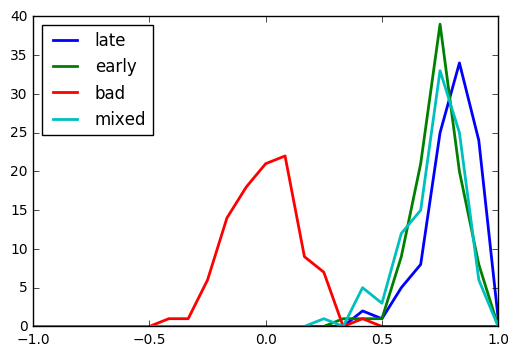

In [21]:
print('T test results: ')
print(t)
printMeanStd(mean_std)
makeHist(allCorrs)

#### Rato 8

In [61]:
bigR8 = loadmat('bigbin_r8.mat')['C']
bigR8 = np.nan_to_num(np.swapaxes(bigR8,0,2))
bigR8.shape

endingDS = bigR10[:28,:10,-100:]
beginningDS = bigR10[:28,:10,:100]
timesToUse = range(10)
trainSize = 80

In [62]:
t,k,mean_std,allCorrs = late_early_bad(endingDS, beginningDS, timesToUse, trainSize, clf=SVC())

T test results: 
{'early_bad': 1.2746979535879495e-11, 'bad_late': 6.532143262106943e-38, 'mixed': 0.063374573266252204, 'early_late': 1.8628929053242724e-12}
Mean    /    Std
{'early': (0.21451805997820564, 0.2509980209877446), 'late': (0.46860732049511017, 0.22318700821637322), 'bad': (-0.017993932765602457, 0.19948247423595244), 'mixed': (0.282046650042798, 0.25789417009053633)}


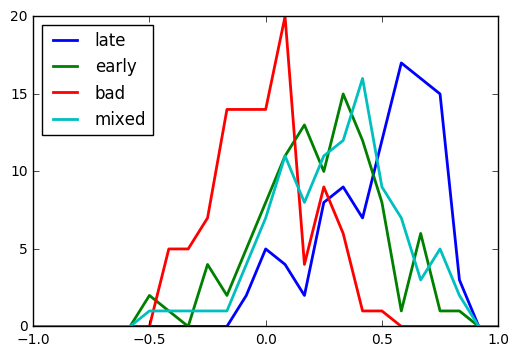

In [63]:
print('T test results: ')
print(t)
print('Mean    /    Std')
print(mean_std)
makeHist(allCorrs)

In [35]:
normR8 = loadmat('normbin_r8.mat')['C']
normR8 = np.nan_to_num(np.swapaxes(normR8,0,2))
print(normR8.shape)

endingDS = normR8[:,:20,-100:]
beginningDS = normR8[:,:20,:100]
timesToUse = range(20)
trainSize = 80

(28, 21, 301)


In [11]:
t,k,mean_std,allCorrs = late_early_bad(endingDS, beginningDS, timesToUse, trainSize)

T test results: 
{'mixed': 2.4202243855525518e-14, 'bad_late': 1.3668386710037731e-83, 'early_bad': 1.3353991464428244e-105, 'early_late': 4.5288616203807742e-15}
Before training (first trials):
Mean corr: 0.796577022542, std: 0.10116536183
After training (last trials):
Mean corr: 0.646620803311, std: 0.141549558317
Mixed predictions (Training late to test early)
Mean corr: 0.654705654953, std: 0.136971116736
Surrogate (bin shuffled)
Mean corr: -0.0130001286427, std: 0.134721880134


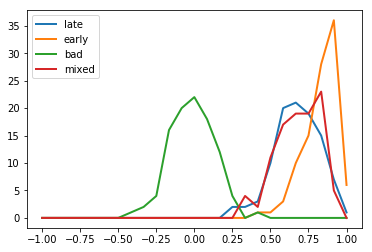

In [13]:
print('T test results: ')
print(t)
printMeanStd(mean_std)
makeHist(allCorrs)

#### Rato 7

In [37]:
bigR7 = loadmat('bigbin_r7.mat')['C']
bigR7 = np.nan_to_num(np.swapaxes(bigR7,0,2))
print(bigR7.shape)

endingDS = bigR7[:23,:10,-100:]
beginningDS = bigR7[:23,:10,:100]
timesToUse = range(10)
trainSize = 80

(23, 20, 454)


In [38]:
%time t,k,mean_std,allCorrs = late_early_bad(endingDS, beginningDS, timesToUse, trainSize, clf=SVC())

Wall time: 9min 55s


T test results: 
{'early_late': 1.6481750514062048e-05, 'early_bad': 1.670774401602781e-25, 'bad_late': 4.2152268984377001e-13, 'mixed': 1.6508743843849516e-08}
Before training (first trials):
Mean corr: 0.456522991571, std: 0.268119354604
After training (last trials):
Mean corr: 0.292624525008, std: 0.253821475112
Mixed predictions (Training late to test early)
Mean corr: 0.22726722108, std: 0.279601112821
Surrogate (bin shuffled)
Mean corr: 0.0215158681262, std: 0.236819945779


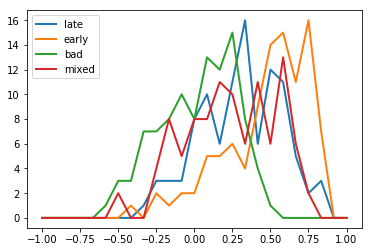

In [39]:
print('T test results: ')
print(t)
printMeanStd(mean_std)
makeHist(allCorrs)

In [28]:
normR7 = loadmat('normbin_r7.mat')['C']
normR7 = np.nan_to_num(np.swapaxes(normR7,0,2))
print(normR7.shape)

endingDS = normR7[:23,:10,-100:]
beginningDS = normR7[:23,:10,:100]
timesToUse = range(10)
trainSize = 80

(23, 21, 454)


In [26]:
t,k,mean_std,allCorrs = late_early_bad(endingDS, beginningDS, timesToUse, trainSize)

T test results: 
{'early_bad': 1.8939521224011189e-33, 'bad_late': 1.6266875755019205e-12, 'mixed': 0.79635752389857406, 'early_late': 4.9146781294534679e-06}
Before training (first trials):
Mean corr: 0.404502332832, std: 0.213539354434
After training (last trials):
Mean corr: 0.239729615228, std: 0.275274033438
Mixed predictions (Training late to test early)
Mean corr: 0.395996234268, std: 0.248319838868
Surrogate (bin shuffled)
Mean corr: -0.014485986752, std: 0.18596113986


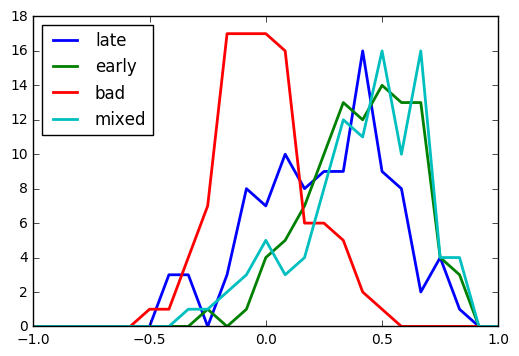

In [27]:
print('T test results: ')
print(t)
printMeanStd(mean_std)
makeHist(allCorrs)

# Decoding from beginning

In [15]:
def fromBeginning(data,timesToUse, trainSize,clf=SVC()):
    endingDS = data[:,:,-100:]
    beginningDS = data[:,:,:]
    
    lateData = DataHandler(endingDS, trainSize)
    lateData.trialShuffle()
    earlyData = DataHandler(beginningDS, trainSize)
    earlyData.trialShuffle()
    
    trainerLate = ClassifierHandler(30,clf) 
    clfLateBox = trainerLate.generateClassifiers(lateData)
    
    predMaker = PredictionsHandler()
    latePreds = predMaker.predictAllResults(lateData, clfLateBox)
    mixedPreds = predMaker.predictAllResults(earlyData, clfLateBox)

    lateCorrs, lateDevs = predMaker.correlate(latePreds, timesToUse,makeStd = True)
    mixedCorrs, mixedDevs = predMaker.correlate(mixedPreds, timesToUse,makeStd = True)
    
    
    return lateCorrs, lateDevs, mixedCorrs,mixedDevs
    

In [12]:
normR7 = loadmat('normbin_r7.mat')['C']
normR7 = np.nan_to_num(np.swapaxes(normR7,0,2))
print(normR7.shape)
normR8 = loadmat('normbin_r8.mat')['C']
normR8 = np.nan_to_num(np.swapaxes(normR8,0,2))
print(normR8.shape)
normR10 = loadmat('normbin_r10.mat')['C']
normR10 = np.nan_to_num(np.swapaxes(normR10,0,2))
print(normR10.shape)

(23, 21, 454)
(28, 21, 301)
(69, 21, 634)


In [32]:
normR10test=normR10[:40,:20,:]
print(normR10test.shape)

(40, 20, 634)


In [16]:
def plotFromBeginning(lateCorrs,mixedCorrs,mixedDevs):
    avgMixed = np.convolve(mixedCorrs,np.ones((30,))/30,'valid')
    avgDev = np.convolve(mixedDevs,np.ones((30,))/30,'valid')
    
    
    #plt.subplot(2,1,1)
    plt.plot(mixedCorrs); plt.plot(range(15,len(mixedCorrs)-14),avgMixed,linewidth=2); 
    plt.plot([0, len(mixedCorrs)],[lateCorrs.mean(), lateCorrs.mean()],color='r')
    plt.fill_between(range(len(avgMixed)),avgMixed-avgDev,avgMixed+avgDev,alpha=1,color='y' )
    #plt.subplot(2,1,2)
    plt.figure(2)
    plt.plot(mixedCorrs[:100]); plt.plot(avgMixed[:100],linewidth=2); 
    plt.plot([0, 100],[lateCorrs.mean(), lateCorrs.mean()],color='r')
    plt.fill_between(range(100),avgMixed[:100]-avgDev[:100],avgMixed[:100]+avgDev[:100],alpha=1,color='y' )

In [35]:
%time lateCorrs, lateDevs, mixedCorrs, mixedDevs = fromBeginning(normR10test, range(20), 80)

Wall time: 17min 59s


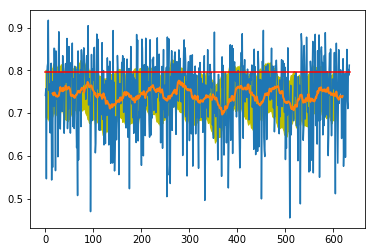

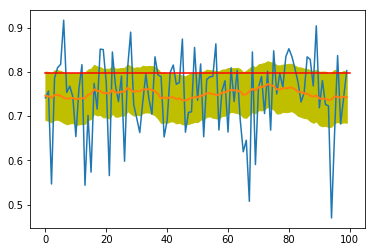

In [147]:
plotFromBeginning(lateCorrs,mixedCorrs,mixedDevs)

In [77]:
%time lateCorrs8, lateDevs8, mixedCorrs8, mixedDevs8 = fromBeginning(normR8[:,:20,:], range(20), 80)

Wall time: 13min 25s


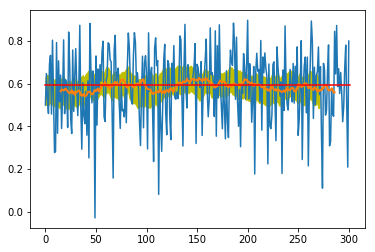

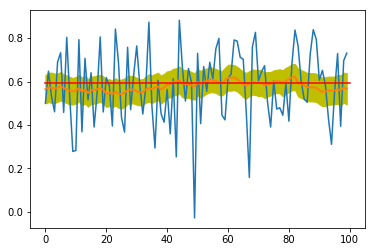

In [149]:
plotFromBeginning(lateCorrs8,mixedCorrs8,mixedDevs8)

In [90]:
%time lateCorrs7, lateDevs7, mixedCorrs7, mixedDevs7 = fromBeginning(normR7[:,:20,:], range(20), 80)

Wall time: 13min 27s


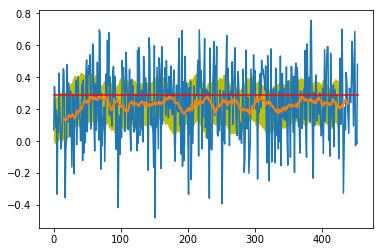

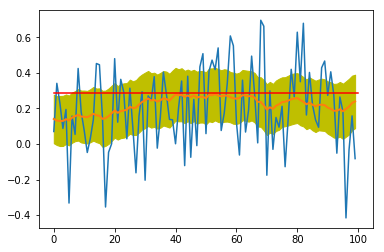

In [151]:
plotFromBeginning(lateCorrs7,mixedCorrs7,mixedDevs7)

In [45]:
bigR7 = loadmat('bigbin_r7.mat')['C']
bigR7 = np.nan_to_num(np.swapaxes(bigR7,0,2))
print(bigR7.shape)

(23, 20, 454)


In [46]:
%time lateCorrsbig7, lateDevsbig7, mixedCorrsbig7, mixedDevsbig7 = fromBeginning(bigR7[:,:10,:], range(10), 80)

Wall time: 3min 26s


In [48]:
lateCorrsbig7.mean()

0.27967893586720693

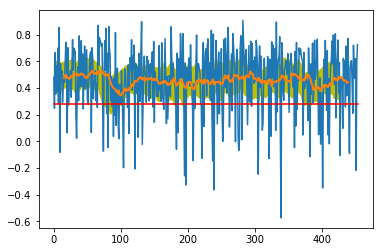

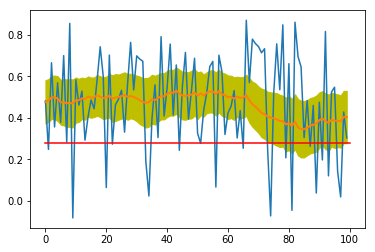

In [49]:
plotFromBeginning(lateCorrsbig7,mixedCorrsbig7,mixedDevsbig7)

## No bundles

In [8]:
normR8 = loadmat('normbin_r8.mat')['C']
normR8 = np.nan_to_num(np.swapaxes(normR8,0,2))
print(normR8.shape)

endingDS = normR8[:,:20,-100:]
beginningDS = normR8[:,:20,:100]
timesToUse = range(20)
trainSize = 80

(28, 21, 301)


In [10]:
dH = DataHandler(endingDS, range(100))
#dH.trialShuffle()
ends = dH.getTrialsData(range(100)) 
dP = DataHandler(beginningDS, range(100))
#dP.trialShuffle()
begs = dP.getTrialsData(range(100))

In [56]:
def trialToXyT(dataset):
    X = np.transpose(dataset).reshape(-1,dataset.shape[0])
    y = np.arange(X.shape[0])%dataset.shape[1]
    trial = np.arange(X.shape[0])//dataset.shape[1]
    return {'X':X,'y':y,'trial':trial}

In [57]:
d = trialToXyT(endingDS)

In [60]:
d['X'].shape

(2000, 28)

In [68]:
np.sum(ends.target==d['y'])

2000

In [48]:
beginningDS.shape

(28, 20, 100)

In [49]:
endingDS.shape

(28, 20, 100)

In [34]:
from sklearn.model_selection import cross_val_score, train_test_split

In [69]:
#score = cross_val_score(SVC(kernel='rbf', C = 16),ends.data,ends.target,cv=8)
Xtrain, Xtest, ytrain,ytest = train_test_split(d['X'],d['y'], test_size=0.1)

In [41]:
ends.data.shape

(2000, 28)

In [22]:
normR8 = loadmat('normbin_r10.mat')['C']
normR8 = np.nan_to_num(np.swapaxes(normR8,0,2))
print(normR8.shape)

endingDS = normR8[:,:20,-100:]
beginningDS = normR8[:,:20,:100]
timesToUse = range(20)
trainSize = 80

(69, 21, 634)


In [23]:
dH = DataHandler(endingDS, range(100))
ends = dH.getTrialsData(range(100)) 
dP = DataHandler(beginningDS, range(100))
begs = dP.getTrialsData(range(100))

In [24]:
Xtrain = ends.data
Xtest = begs.data
ytrain = ends.target
ytest = begs.target

In [25]:
clf = SVC(kernel='rbf', C = 16, gamma= 0.0058)
clf.fit(Xtrain,ytrain)

SVC(C=16, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0058, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
ypred = clf.predict(Xtest)

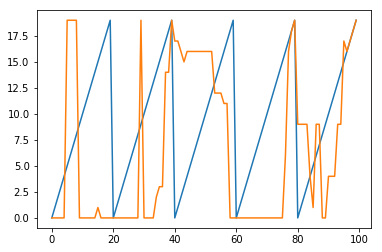

In [27]:
plt.plot(ytest[0:100])
plt.plot(ypred[0:100])

In [28]:
r,p = pearsonr(ypred,ytest)
print(r)

0.379043247353


# Temporal generalization

In [52]:
normR8 = loadmat('normbin_r10.mat')['C']
normR8 = np.nan_to_num(np.swapaxes(normR8,0,2))
print(normR8.shape)

endingDS = normR8[:,:20,-100:]
beginningDS = normR8[:,:20,:100]
timesToUse = range(20)
trainSize = 80

(69, 21, 634)


In [53]:
clf = SVC()
trainerLate = ClassifierHandler(30,clf,SVC(kernel='rbf', C = 16))
predMaker = PredictionsHandler()
lateData = DataHandler(endingDS, trainSize)
clfLateBox = trainerLate.generateClassifiers(lateData)
latePreds = predMaker.predictAllResults(lateData, clfLateBox)


KeyboardInterrupt: 

In [ ]:
allPreds = np.array(list(latePreds.getPredictions().values()))
allPreds.shape

In [146]:
N = allPreds.shape[2]
tGen = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        tGen[i,j] = np.sum(allPreds[:,:,i]==j)

In [147]:
tNorm = tGen/(np.array([tGen.max(axis=1)]).transpose())

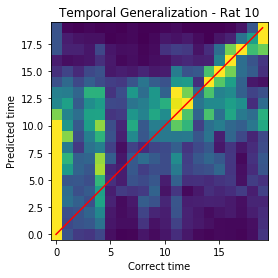

In [151]:
plt.imshow(tNorm,cmap='viridis',origin='lower')
plt.plot(np.arange(20),np.arange(20),'r')
plt.title('Temporal Generalization - Rat 10')
plt.xlabel('Correct time'); plt.ylabel('Predicted time')

## Beginning vs end

In [260]:
from sklearn.metrics import f1_score
from Suvrellib import Suvrel
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [244]:
Xtrain = np.vstack([ends.data[:1600,:],begs.data[:1600,:]]);Btt = np.hstack([ends.target[:1600],begs.target[:1600]])
ytrain = np.vstack([np.ones([1600,1]),np.zeros([1600,1])]).ravel()
Xtest = np.vstack([ends.data[1600:,:],begs.data[1600:,:]]);Btg = np.hstack([ends.target[1600:],begs.target[1600:]])
ytest = np.vstack([np.ones([400,1]),np.zeros([400,1])]).ravel()

In [243]:
score=[]
for i in range(20):
    clf = SVC(kernel='linear', C = 20)
    clf.fit(Xtrain[Btt==i,:],ytrain[Btt==i])
    ypred = clf.predict(Xtest[Btg==i,:])
    score.append(f1_score(ytest[Btg==i],ypred))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 3200

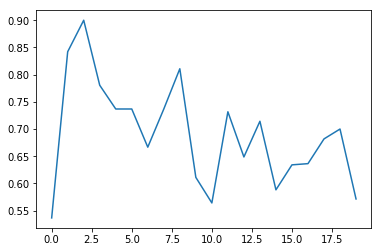

In [230]:
plt.plot(score)

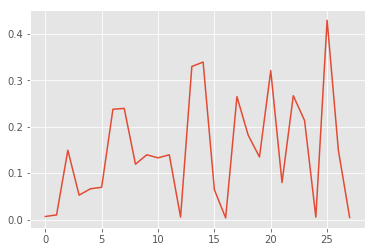

In [358]:
clf = Suvrel()
suvXtrain = clf.fit_transform(Xtrain[Btt==2,:],ytrain[Btt==2])
plt.plot(clf.gamma_)

In [359]:
from sklearn.decomposition import KernelPCA
pcf = PCA()
pcf.fit(Xtrain[Btt==2,:])
transf = pcf.transform(Xtrain[Btt==2,:])
transf.shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 3200

In [360]:
from sklearn.decomposition import KernelPCA
pcf = PCA()
pcf.fit(suvXtrain)
transf = pcf.transform(suvXtrain)
transf.shape

(160, 28)

(160, 1, 3)
(159, 2, 3)


(-0.5, 0.5)

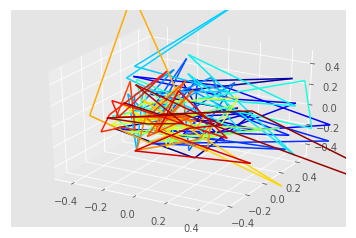

In [370]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

x = transf[:,0]
y = transf[:,1]
z = transf[:,2]
t = np.arange(160)

# generate a list of (x,y,z) points
points = np.array([x,y,z]).transpose().reshape(-1,1,3)
print(points.shape)  # Out: (len(x),1,2)

# set up a list of segments
segs = np.concatenate([points[:-1],points[1:]],axis=1)
print(segs.shape)  # Out: ( len(x)-1, 2, 2 )
                  # see what we've done here -- we've mapped our (x,y)
                  # points to an array of segment start/end coordinates.
                  # segs[i,0,:] == segs[i-1,1,:]

# make the collection of segments
lc = Line3DCollection(segs, cmap=plt.get_cmap('jet'))
lc.set_array(t) # color the segments by our parameter

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.add_collection3d(lc)
ax.set_xlim3d(-.5,.5)
ax.set_ylim3d(-.5,.5)
ax.set_zlim3d(-.5,.5)

In [293]:
from sklearn.manifold import MDS

In [371]:
mdf = MDS(n_components=3)
transf = mdf.fit_transform(suvXtrain)
transf.shape

(160, 3)

(160, 1, 3)
(159, 2, 3)


(-0.4, 0.4)

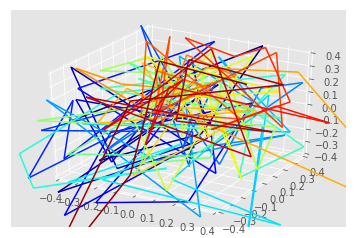

In [373]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

x = transf[:,0]
y = transf[:,1]
z = transf[:,2]
t = np.arange(160)

# generate a list of (x,y,z) points
points = np.array([x,y,z]).transpose().reshape(-1,1,3)
print(points.shape)  # Out: (len(x),1,2)

# set up a list of segments
segs = np.concatenate([points[:-1],points[1:]],axis=1)
print(segs.shape)  # Out: ( len(x)-1, 2, 2 )
                  # see what we've done here -- we've mapped our (x,y)
                  # points to an array of segment start/end coordinates.
                  # segs[i,0,:] == segs[i-1,1,:]

# make the collection of segments
lc = Line3DCollection(segs, cmap=plt.get_cmap('jet'))
lc.set_array(t) # color the segments by our parameter

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.add_collection3d(lc)
ax.set_xlim3d(-.4,.4)
ax.set_ylim3d(-.4,.4)
ax.set_zlim3d(-.4,.4)